*The major transfer learning scenarios look as follows:*

* **ConvNet as Fixed Feature Extractor:** Take a CNN model which is trained on large dataset, remove the last fully connected layer then keep the rest as fixed feature extractor for the new dataset.
* **Fine Tuning the ConvNet:** This method fine tune the weights of the pretrained network*(continuing the backpropagation)* with the new dataset. It is possible to fine tune all the layers of the convnet or it is possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine tune some layers of the network*(early layers of the network contain more h=generic features like edges, color detector features which are common to many tasks , later layers of the network are more specific to the task)*.


**When and How to fine tune**

* How to you decide what type of TL should we perform on a new dataset?
    * it depends on the size of the new dataset
    * similarities to the original dataset
    1. New dataset is small and similar to original dataset: As the dataset is small, it is not a good idea to fine tune the cnn due to overfittinf concerns. And the dataset is similar to the original data, we expect that the higher level features in the cnn to be relevant to this dataset as well. THe best idea might be to train a linear classifier on the CNN
    2. New dataset is large and similar to the original dataset: as the dataset is more so there wonot be overfit if we try to fine tune through the full network.
    3. New dataset is small but very differnet fro mthe orginal dataset:  Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.
    4. New dataset is large and very different from the original dataset:  Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.

**Keep in Mind** when performing transfer learning:

1. Constraints from pretrained models:
  * canot arbitrarily take out conv layers from the pretrained network
  * can run on a pretraiend network with images of different spatial size, due to parameter sharing.

2. Learning Rates:
  * use a smaller learning rate for convnet weights that are being fine tuned, in comparision to the randomly initialized weights for the new linear classifier that computes the class scores of your new dataset(This is because we expect that the ConvNet weights are relatively good, so we don’t wish to distort them too quickly and too much especially while the new Linear Classifier above them is being trained from random initialization).

Links

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://cs231n.github.io/transfer-learning/



In [ ]:
!ls

sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!ls drive/MyDrive/transfer_learning/

hymenoptera_data


In [ ]:
!ls drive/MyDrive/transfer_learning/hymenoptera_data/val/bees/72100438_73de9f17af.jpg

drive/MyDrive/transfer_learning/hymenoptera_data/val/bees/72100438_73de9f17af.jpg


In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/MyDrive/transfer_learning/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
print(f"image_datasets: {image_datasets['train']}")
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

print()
print(f"Dataloaders: {dataloaders}")
print(f"Dataloaders   train: {dataloaders['train']}")
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(f"dataset sizes : {dataset_sizes}")
class_names = image_datasets['train'].classes
print(f"class names: {class_names}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_datasets: Dataset ImageFolder
    Number of datapoints: 244
    Root location: drive/MyDrive/transfer_learning/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Dataloaders: {'train': <torch.utils.data.dataloader.DataLoader object at 0x7cc72e612b00>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7cc72e612ce0>}
Dataloaders   train: <torch.utils.data.dataloader.DataLoader object at 0x7cc72e612b00>
dataset sizes : {'train': 244, 'val': 153}
class names: ['ants', 'bees']


In [ ]:
it = iter(dataloaders['train'])
print(f"it : {it}")
first = next(it)
#print(first)
second = next(it)
#print(second)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


it : <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7cc72e529420>


#Visualizing the images

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([3, 228, 906])


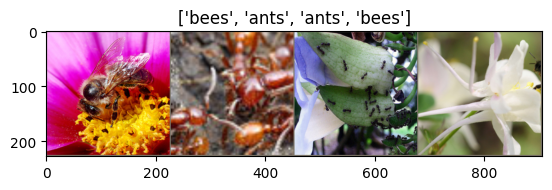

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    print(inp.shape)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

iter() -- returns an iterator object from an iterable (`dataloaders['train']`). which allows us to iterate over elements of container(like list or dataset)

---

next() -- used to get the next item from an iterator. In the above case, it retrives the next batch of data from the iterator created by `iter(dataloaders['train'])`

---
In short:
```
inputs, classes = next(iter(dataloaders['train']))
```
The dataloaders['train'] object is the iterable, and iter() is used to create an iterator from it. The next() function is then used to obtain the next batch of data from that iterator.


In [ ]:
type(out)

torch.Tensor

`torchvision.utils.make_grid()` returns a tensor which contains the grid of images.

In PyTorch and many other deep learning frameworks, the convention for image tensors is often (channels, height, width).

transpose((1, 2, 0)): Transposes the axes of the NumPy array. In this case, it changes the order of axes from (channels, height, width) to (height, width, channels).

So, the transpose operation is a way to adjust the tensor's dimensions to align with the expected format for displaying images with matplotlib

In Matplotlib, the convention for displaying images is (height, width, channels)

Therefore, when you use Matplotlib's imshow function, it is assumed that the image data is in the HWC format. If your image data is in CHW (channels, height, width) format, as is common in deep learning frameworks like PyTorch, you may need to transpose the axes to HWC before using imshow. The transposition can be done using the numpy.transpose function.

#Training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

optimizer.zero_grad() method is used to clear out the gradients of all parameters that the optimizer is tracking

**The optimization process involves adjusting the parameters of a model to minimize a loss function.** During the training of neural networks, the optimizer is responsible for updating the model's parameters based on the computed gradients of the loss with respect to those parameters.

optimizer.zero_grad() is a method used to zero out or reset the gradients of all the trainable parameters in the model. This is typically done before computing the gradients in the backward pass. The reason for zeroing the gradients is to prevent the gradients from accumulating across multiple iterations of the training loop.

---

In training neural networks, the process of backpropagation is used to compute the gradients of the loss with respect to the model parameters. These gradients are then used to update the parameters of the model in the direction that reduces the loss. The steps involved in this process are loss.backward() and optimizer.step().

Here's an explanation of each step:

**loss.backward():**

This line computes the gradient of the loss with respect to all the parameters in the model. It essentially calculates how much each model parameter contributed to the error.
The gradients are stored in the model's parameters, allowing the optimizer to later use them to update the model.

**optimizer.step():**

The optimizer is responsible for updating the model's parameters during training.

After the gradients are computed using loss.backward(), the optimizer takes a step in the direction that reduces the loss by adjusting the model parameters.
The step() function is responsible for applying the optimization algorithm (e.g., stochastic gradient descent, Adam, etc.) to update the model's parameters.
It updates the parameters based on the gradients and the specified learning rate.

The StepLR scheduler is a learning rate scheduler in PyTorch that decreases the learning rate by a given factor (gamma) every specified number of epochs (step_size). It's part of the torch.optim.lr_scheduler module.


The scheduler.step() function is used to update the learning rate of an optimizer during training. Learning rate scheduling is a technique where the learning rate is adjusted at specific points during training to improve the convergence and performance of the model.

Learning Rate Scheduler Initialization:

 typically create a learning rate scheduler and associate it with an optimizer when setting up your training loop.
 `scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)`


 from the above code sets up a learning rate scheduler that decreases the learning rate by a factor of 0.1 every 7 epochs. This kind of learning rate decay strategy is commonly used to help models converge more effectively during training.

for saving and loading models https://pytorch.org/tutorials/beginner/saving_loading_models.html

a serialized object: refers to the process of converting a data structure or object into a format that can be easily stored or transmitted and later reconstructed. Serialization allows objects to be saved to files, sent over networks, or otherwise persisted in a structure format.
* In context to deep learning framework pytorch, serialization is often used to save models, tensors, or other object to files.
* this process enables the preservation of the model's state or other relevant information, making it possible to reload the model at a later time for inference, further training, or analysis.
* `torch.save()` is for serialization
* `torch.load()` is for deserializating the saved data to reconstruct the orginal model object.

When you try to open a .pth file using a text editor, you will likely see non-human-readable characters and binary data. This is because the file is not encoded in plain text but in a serialized binary format.

The .pth file created by PyTorch's torch.save() function is not meant to be human-readable. It's a binary file that contains serialized data in PyTorch's native format. This binary format is designed for efficient storage and retrieval of complex data structures, such as models and their parameters.

#Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#FInetuning the ConvNet

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


#Train and Evalute

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5859 Acc: 0.8033
val Loss: 0.4059 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4536 Acc: 0.8525
val Loss: 0.3111 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.3226 Acc: 0.8525
val Loss: 0.3048 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.2340 Acc: 0.9221
val Loss: 0.2781 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.1967 Acc: 0.9221
val Loss: 0.2935 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.3958 Acc: 0.8279
val Loss: 0.2718 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.2836 Acc: 0.8607
val Loss: 0.2765 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3276 Acc: 0.8689
val Loss: 0.2501 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2681 Acc: 0.8852
val Loss: 0.2397 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2470 Acc: 0.8975
val Loss: 0.2553 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3279 Acc: 0.8484
val Loss: 0.2273 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3857 Acc: 0.8525
val Loss: 0.2435 Acc: 0.9150

Ep

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='drive/MyDrive/transfer_learning/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

# For creating Custom Dataset

**use torch.utils.data.Dataset to create a custom dataset**

When we want to create a custom dataset for our specific task or use case, we usually subclass torch.utils.data.Dataset and implement the __len__ and __getitem__ methods.

we could use torch.utils.data.Dataset when we need a custom dataset class that is tailored to our data format, loading procedure, and preprocessing.

the following link https://pytorch.org/tutorials/beginner/basics/data_tutorial.html has content how to creat a custom dataset for your files

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

# Example usage
custom_data = [([1, 2, 3], 0), ([4, 5, 6], 1), ([7, 8, 9], 0)]
custom_dataset = CustomDataset(data=[sample[0] for sample in custom_data],
                                labels=[sample[1] for sample in custom_data])

# Accessing the dataset
for i in range(len(custom_dataset)):
    data, label = custom_dataset[i]
    print(f"Sample {i + 1}: Data={data}, Label={label}")


#Predefined Dataset

**use torchvision.datasets to work with a predefined dataset (MNIST in this case)**

In [ ]:
from torchvision import datasets, transforms

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

# Example usage
# Accessing the dataset
for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    print(f"Sample {i + 1}: Label={label}")


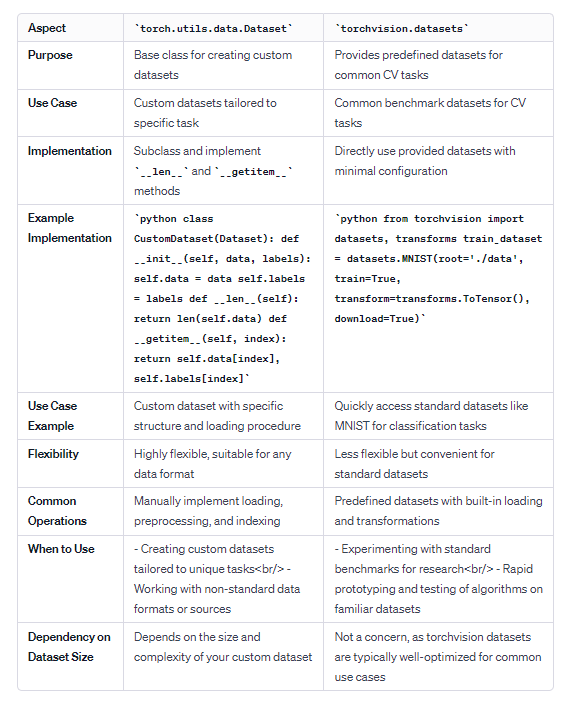

 **What torch and torchivision contains**


 The package torch consists of all the core classes and methods required to implement neural networks, while torchvision is a supporting package consisting of popular datasets, model architectures, and common image transformations for computer vision. There is one more package named torchtext which has all the basic utilities of PyTorch Natural Language Processing. This package consists of datasets that are related to text.

Note: generic data loader classes means users can customize based on their specific needs.

#ImageFolder class



* it is a generic data loader class in torchvision that helps to load our own image dataset

* IF we are working on classification problem and buildling a neural network to identify if a given image is cat or dog then first step is to arrange images in a folder structure manner

example:

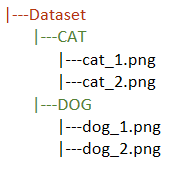


once the data is arrange as shown above use the ImageFOlder class to load all the images.
`torchvision.dataset.ImageFolder()`

 https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder





* Datasets in torchvision:
  * MNIST: it is a dataset consisting of handwritten images that are normalized and center cropped.
    * 60,000 - training images
    * 10,000 - testing images
    * `torchvision.datasets.MNIST()`

  * Fashion MNIST: This dataset is similar to MNIST
    * but instead of handwritten digits, this dataset includes clothing items like T-shirts, trousers, bags etc.,
    * 60,000 - training images
    * 10,000 - testing images
    * `torchvision.datasets.FashionMNIST()`

  * CIFAR: has two versions
    * CIFAR10: consists of images of 10 different labels
    * CIFAR100: has 100 different classes
    * These include images like trucks, frogs, boats, cars, deer
    * `torchvision.datasets.CIFAR10()`
    * `torchvision.datasets.CIFAR100()`

  * COCO: contains 1,00,000 everyday objects like people, bottles, stationery, books
    * used in object detection and image captioning applications
    * `torchvision.datasets.CocoCaptions()`

  * EMNIST: advanced version of MNIST dataset
    * consists of numbers and alphabets'* useful in recognizing text from images
    * `torchvision.datasets.EMNIST()`

  * IMAGE-NET: used to train high end neural networks
    * constains 1.2 million mages spread across 10,000 classes
    * `torchvision.datasets.ImageNet()`

* links:
  * https://www.geeksforgeeks.org/how-to-use-a-dataloader-in-pytorch/

  * https://blog.paperspace.com/dataloaders-abstractions-pytorch/

* Dataloader class handles the loading and handling different types of data(csv files, images, text) and iterate over elements in a dataset.
```
from torch.utils.data import DataLoader
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )
```


**Looking at the MNIST Dataset**

In [ ]:
# Import MNIST
from torchvision.datasets import MNIST

# Download and Save MNIST and load it to a variable datta_train
data_train = MNIST('~/mnist_data', train=True, download=True)

# Print Data
print(data_train)
print(data_train[12])


In [ ]:
print(data_train)
print()
print(data_train[0])
print()
print(data_train[0][0])

When you see a message like "PIL.Image.Image image mode=L size=28x28 at 0x7CC73B74DDB0," it indicates that you have an image object of size 28x28 pixels with a mode of 'L', which typically stands for grayscale. The hexadecimal number (e.g., 0x7CC73B74DDB0) is the memory address of the image object.

In [ ]:
import matplotlib.pyplot as plt
randm_img = data_train[0][0]
randm_img_label = data_train[0][1]

plt.show(randm_img)

We send the model matries which contain the images rather than just images wiht indices.

In [ ]:
import torch
from torchvision import transforms

data_train = torch.utils.data.DataLoader(MNIST(
    '~/mnist_data', train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=64,
    shuffle=True
)
for batch_idx,samples in enumerate(data_train):
  #print(batch_idx,samples)
  break

In [ ]:
print(type(samples))
print(len(samples))
print(samples[0].shape)
print(samples[0][0].shape)
print(type(samples[0][0]))


<class 'list'>
2
torch.Size([64, 1, 28, 28])
torch.Size([1, 28, 28])
<class 'torch.Tensor'>


In [ ]:
data_train

Dataset stores the samples and their corresponding labels.
```
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

```
torch.utils.data.Dataset:
* A base class in PyTorch for creating custom datasets.
* To use it, you need to subclass it and implement the __len__ and __getitem__ methods.
* Represents a source of data and defines how the data is loaded, preprocessed, and indexed.
* Provides a consistent interface for accessing samples in the dataset.


---




Dataloader wraps an iterable around the Dataset to enable easy access to the samples.
```
from torch.utils.data import DataLoader

# Assuming 'custom_dataset' is an instance of CustomDataset
custom_dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)
```
* Allows parallelizing data loading by using multiple processes.
* Handles batching, shuffling, and other data-loading parameters.
* Simplifies the process of loading and preprocessing data for training or evaluation.


---


Key Differences:
* Dataset is responsible for providing a way to access individual samples and their corresponding labels.
* DataLoader is responsible for managing the loading and batching of samples from the dataset, handling parallel processing, shuffling, and other data-loading optimizations.
* You use Dataset to define the structure and access patterns for your data, while you use DataLoader to efficiently load and process that data in mini-batches during training or evaluation.


